# EDA

Dataset Shape: (678013, 11)

First few rows of the dataset:
       ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                           
1            1      0.10    D         5       0       55          50      B12   
3            1      0.77    D         5       0       55          50      B12   
5            1      0.75    B         6       2       52          50      B12   
10           1      0.09    B         7       0       46          50      B12   
11           1      0.84    B         7       0       46          50      B12   

          VehGas  Density Region  
IDpol                             
1      'Regular'     1217    R82  
3      'Regular'     1217    R82  
5       'Diesel'       54    R22  
10      'Diesel'       76    R72  
11      'Diesel'       76    R72  

Summary statistics:
             ClaimNb       Exposure       VehPower         VehAge  \
count  678013.000000  678013.000000  

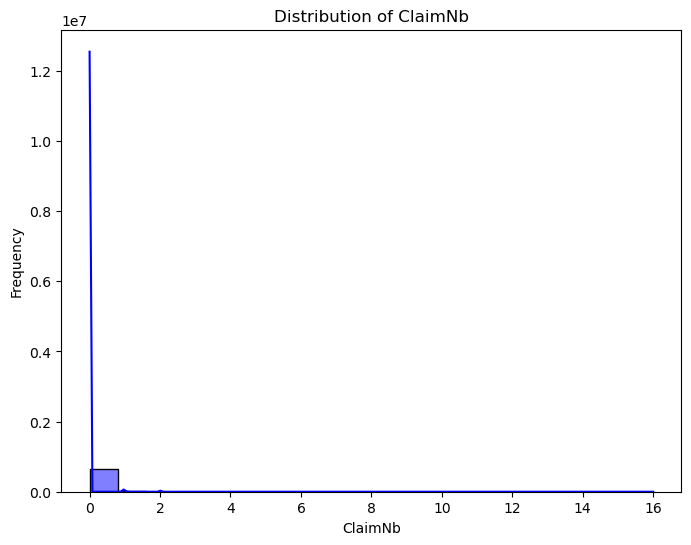

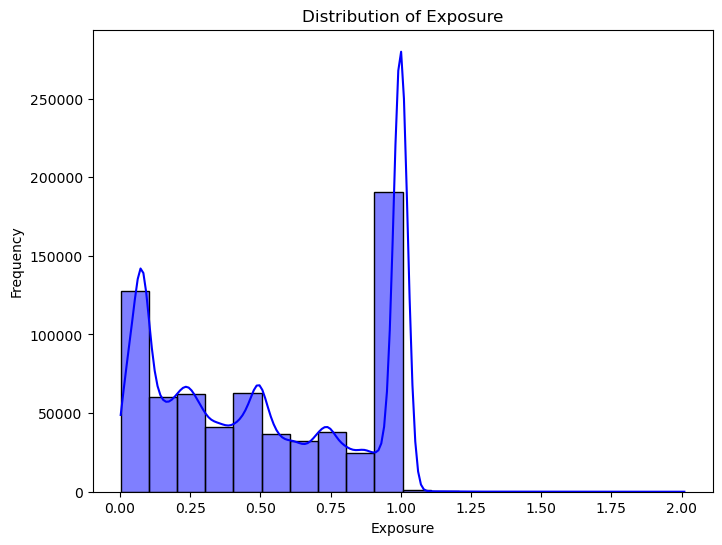

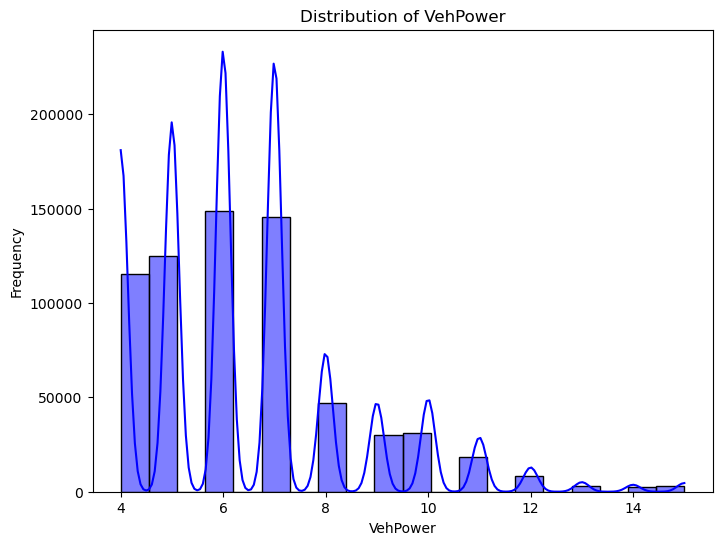

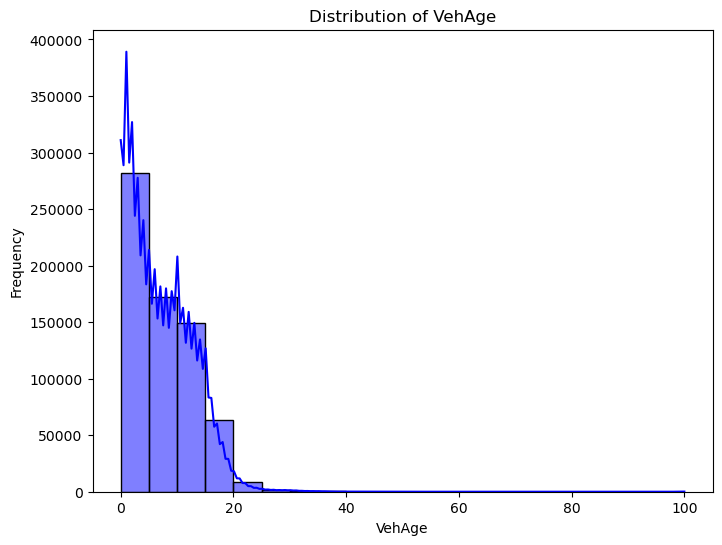

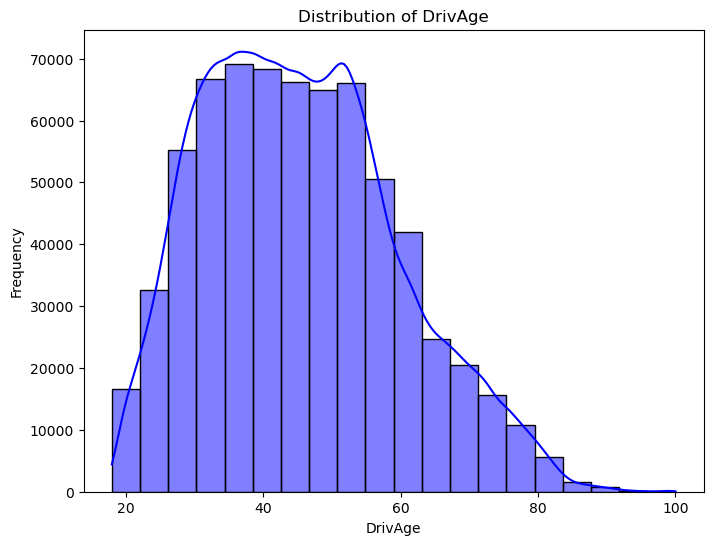

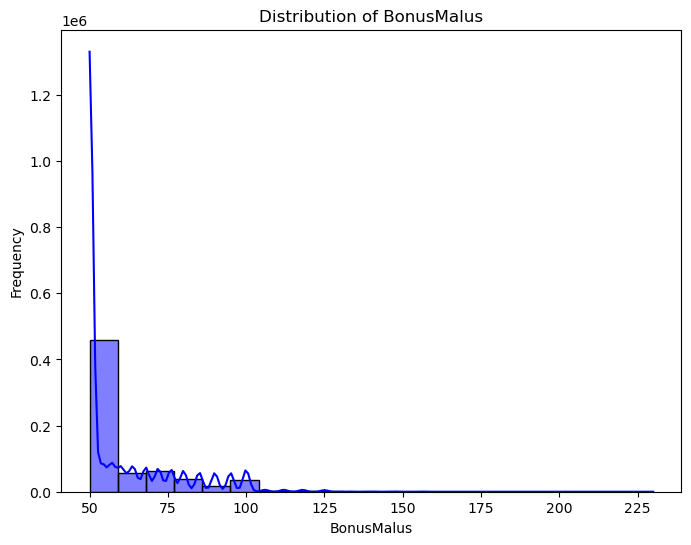

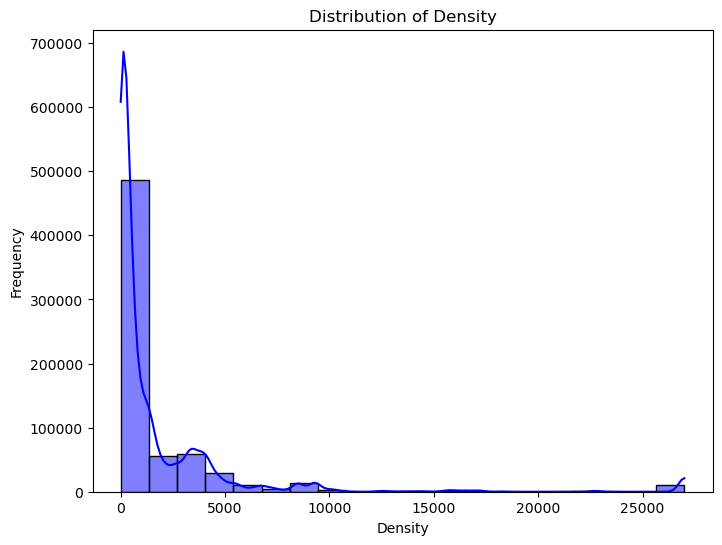


Visualising correlation between numerical features:


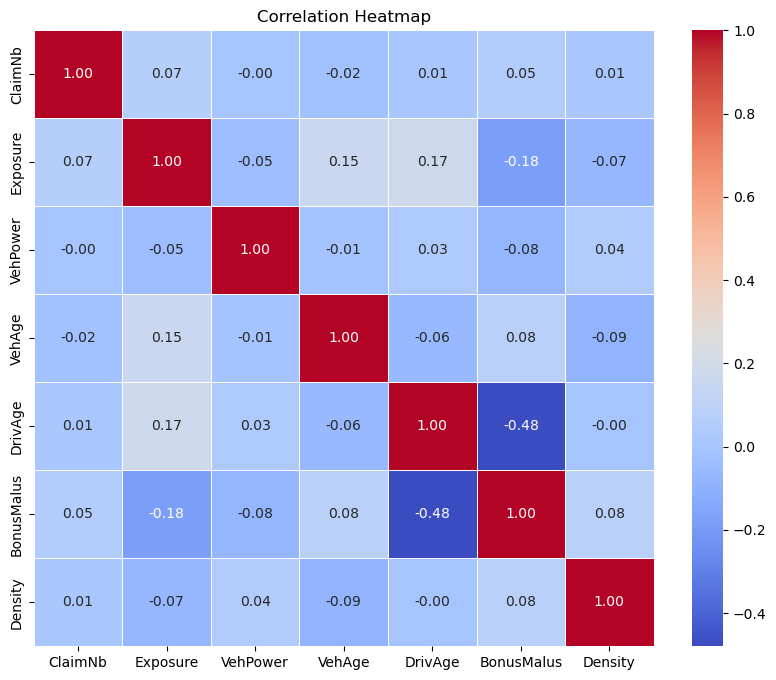


Visualising categorical features:


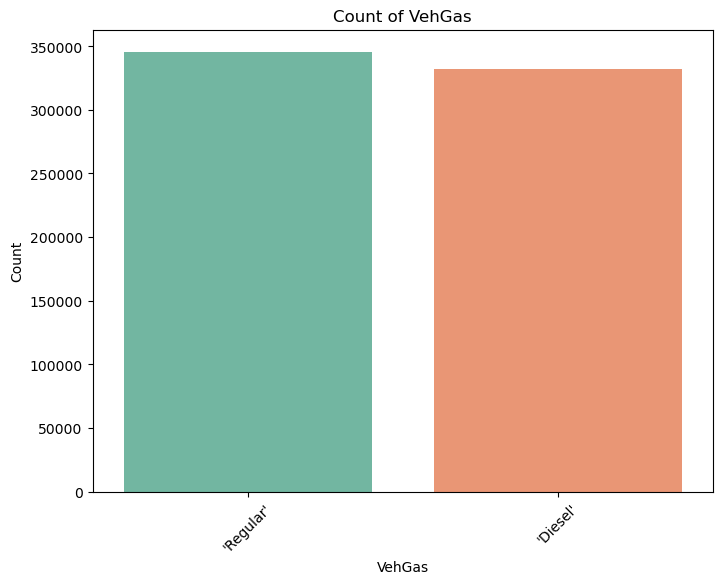

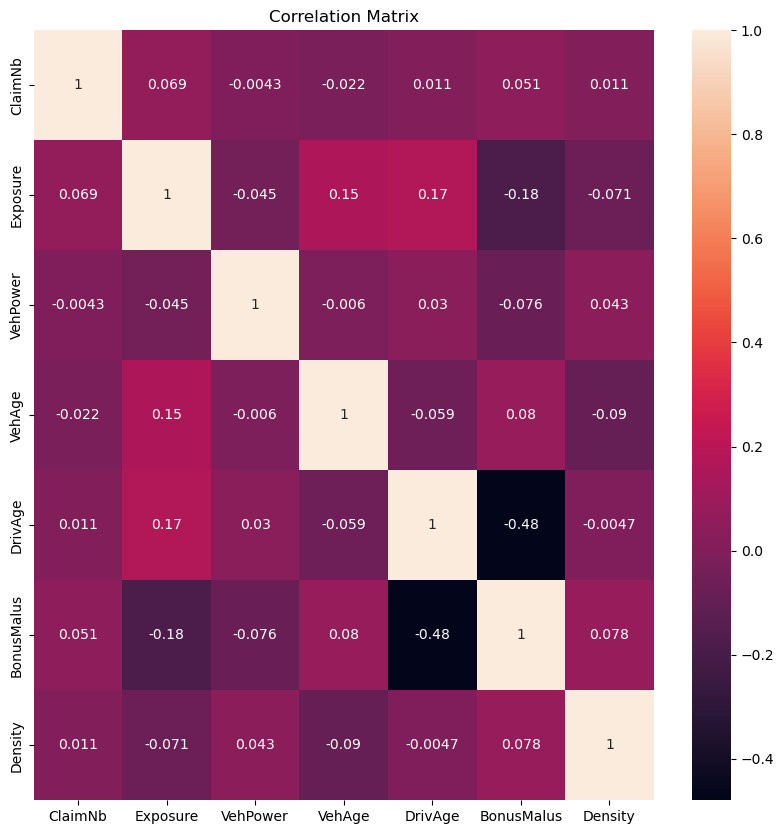

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
def load_mtpl2(n_samples=None):
    df_freq = fetch_openml(data_id=41214, as_frame=True).data
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)
    return df_freq

# Load the data
df = load_mtpl2()

# Displaying basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())
print("\nSummary statistics:")
print(df.describe())

# Checking for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Visualising the distribution of numerical features
print("\nVisualising distribution of numerical features:")
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[feature], kde=True, bins=20, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Visualising correlation between numerical features
print("\nVisualising correlation between numerical features:")
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Visualising categorical features
print("\nVisualising categorical features:")
categorical_features = df.select_dtypes(include=['object']).columns
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, palette='Set2')
    plt.title(f'Count of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Plot the correlation matrix of the numerical features
plt.figure(figsize=(10, 10))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

# REBAGG

In [50]:
import numpy as np
import seaborn as sns
import itertools
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_california_housing as dataset
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, '..')
import resreg

# Hyperparameters
sizes = [0.25, 0.5]  # size of bootstrap sample as a fraction of total size
size_methods = ['balance', 'variation'] # whether to select equal samples from rare and normal domains
params = list(itertools.product(sizes, size_methods))

# Grid search
r2store, f1store, msebinstore = [], [], [] # Empty lists for storing results
r2errstore, f1errstore, msebinerrstore = [], [], []

for param in params:
    s, size_method = param

    # Fivefold cross validation (fit ensemble and evaluate performance on test set)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] # Empty lists to store results
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=[3.5]) # right-sided relevance function

        # Fit rebagg ensemble using random oversampling to oversample the rare domain
        reg = DecisionTreeRegressor(max_features=0.5, random_state=0)  # base learner
        rebagg = resreg.Rebagg(m=50, s=s, base_reg=reg) # create a rebagg instance
        rebagg.fit(X_train, y_train, relevance=relevance, relevance_threshold=0.5, 
                    sample_method='random_oversample', size_method=size_method, random_state=0)

        # Evaluate performance on testing set
        y_pred = rebagg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rel_test = resreg.sigmoid_relevance(y_test, cl=None, ch=[3.5]) # relevance values of y_test
        rel_pred = resreg.sigmoid_relevance(y_pred, cl=None, ch=[3.5]) # relevance values of y_pred
        f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=rel_test,
                                relevance_pred=rel_pred, relevance_threshold=0.5)
        msebin = resreg.bin_performance(y_test, y_pred, bins=[3.5], metric='mse')
        r2s.append(r2); f1s.append(f1); msebins.append(msebin)

    # Average performance over fivefold cross validation
    r2, f1, msebin = np.mean(r2s), np.mean(f1s), np.mean(msebins, axis=0) # average over 5fold cross validation
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), np.std(msebins, axis=0)/np.sqrt(5) # standard error

    # Save grid search results
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)

# View performance of best hyperparameters
best = np.argsort(f1store)[-1] # Which is the best
bestparams = params[best]
print(f'''Best parameters: 
      s={bestparams[0]}, size_method={bestparams[1]}''')
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Plot results
bins=[3.5]
ticks_font = {'size':'12'}
label_font = {'size':'14'}
title_font = {'size':'16'}

def plotPerformance(msebin, msebinerr, f1, r2, title):
    plt.bar(range(2), msebin, yerr=msebinerr, width=0.4, capsize=3, color='royalblue',
           linewidth=1, edgecolor='black')
    plt.xlim(-0.5, len(bins)+0.5)
    plt.xticks(range(2), ['< {0}'.format(bins[0]), '≥ {0}'.format(bins[0])], **ticks_font)
    plt.yticks(**ticks_font)
    plt.ylabel('Mean Squared Error (MSE)', **label_font)
    plt.xlabel('Target value range', **label_font)
    title = title + '\\\\nf1={0}, r2={1}'.format(round(f1,3), round(r2,3))
    plt.title(title, **title_font)
    plt.show()
    plt.close()

plotPerformance(msebin, msebinerr, f1, r2, title='REBAGG-RO')

# Save results
CACHE = joblib.load('cache.pkl')
CACHE['REBAGG-RO'] = [r2, f1, msebin, r2err, f1err, msebinerr]

ValueError: 'a' cannot be empty unless no samples are taken

In [19]:
## load dependencies
import ImbalancedLearningRegression as iblr
import pandas
import seaborn
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import itertools
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

#from sklearn.datasets import fetch_california_housing as dataset
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, '..')
import resreg


In [17]:
# ignore warnings
import warnings

warnings.filterwarnings("ignore")

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import itertools

In [25]:
def load_mtpl2(n_samples=None):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=None
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True).data
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True).data

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby("IDpol").sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]


try:
    # load data from local pickle
    df = pd.read_pickle("mtpl2.pkl")
except FileNotFoundError:
    # or download from openml
    df = load_mtpl2()
    df.to_pickle("mtpl2.pkl")

df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1.0,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
3.0,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
5.0,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
10.0,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
11.0,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93,0.0
6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11,0.0
6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82,0.0


In [3]:
df.info() #Area,VehBrand,Region,VehGas

<class 'pandas.core.frame.DataFrame'>
Float64Index: 678013 entries, 1.0 to 6114330.0
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   ClaimNb      678013 non-null  float64 
 1   Exposure     678013 non-null  float64 
 2   Area         678013 non-null  category
 3   VehPower     678013 non-null  float64 
 4   VehAge       678013 non-null  float64 
 5   DrivAge      678013 non-null  float64 
 6   BonusMalus   678013 non-null  float64 
 7   VehBrand     678013 non-null  category
 8   VehGas       678013 non-null  object  
 9   Density      678013 non-null  float64 
 10  Region       678013 non-null  category
 11  ClaimAmount  678013 non-null  float64 
dtypes: category(3), float64(8), object(1)
memory usage: 53.7+ MB


In [4]:
df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06


In [5]:
# Remove outliers
# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

# If the claim amount is 0, then we do not count it as a claim. The loss function
# used by the severity model needs strictly positive claim amounts. This way
# frequency and severity are more consistent with each other.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

df["Frequency"] = df["ClaimNb"] / df["Exposure"]
# df = df.drop(columns=["ClaimNb", "Exposure", "ClaimAmount"])
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Frequency
IDpol,,,,,,,,,,,,,
1.0,0.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0
3.0,0.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0
5.0,0.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0,0.0
10.0,0.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0
11.0,0.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93,0.0,0.0
6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11,0.0,0.0
6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82,0.0,0.0


In [26]:
df["ClaimNb"].unique()

array([ 1.,  2.,  4.,  3., 11.,  0.,  5.,  6.,  8., 16.,  9.])

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

# log_scale_transformer = make_pipeline(
#     FunctionTransformer(func=np.log), StandardScaler()
# )
# 
# column_trans = ColumnTransformer(
#     [
#         (
#             "BN",  # binned_numeric
#             KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
#             ["VehAge", "DrivAge"],
#         ),
#         (
#             "OH",  # onehot_categorical
#             OneHotEncoder(),
#             ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
#         ),
#         # ("passthrough_numeric", "passthrough", ["BonusMalus"]),
#         # ("log_scaled_numeric", log_scale_transformer, ["Density"]),
#     ],
#     remainder="passthrough",
# )
# 
# df = pd.DataFrame(column_trans.fit_transform(df).toarray(), columns=column_trans.get_feature_names_out())
# df = df.rename(
#     columns={_: _.replace("__", "_") if "remainder__" not in _ else _.replace("remainder__", "") for _ in df.columns})


# set categorical columns
categorical_columns = ["VehBrand", "VehPower", "VehGas", "Region", "Area"]
df[categorical_columns] = df[categorical_columns].astype("category")

# standard_scaler = StandardScaler()
# df["Density"] = standard_scaler.fit_transform(np.log(df["Density"]).values.reshape(-1, 1))
df["Density"] = np.log(df["Density"])
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Frequency
IDpol,,,,,,,,,,,,,
1.0,0.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,7.104144,R82,0.0,0.0
3.0,0.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,7.104144,R82,0.0,0.0
5.0,0.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,3.988984,R22,0.0,0.0
10.0,0.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,4.330733,R72,0.0,0.0
11.0,0.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,4.330733,R72,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,8.106816,R93,0.0,0.0
6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9.195227,R11,0.0,0.0
6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,7.187657,R82,0.0,0.0


In [51]:
#!pip install resreg

In [10]:
import pandas as pd
df.reset_index(drop=True, inplace=True)

# Assuming df is your original DataFrame

# Randomly sample 500 rows
sampled_df = df.sample(n=500, random_state=42)  # You can adjust the random_state for reproducibility

# Create X and y variables
X = sampled_df.drop(columns=["ClaimNb", "Exposure", "ClaimAmount", "Frequency","Area","VehBrand","Region","VehGas"])
y = sampled_df["ClaimNb"]

X = X.values
y = y.values

# Now you can use X and y for further analysis or modeling



In [11]:
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Frequency
0,0.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,7.104144,R82,0.0,0.0
1,0.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,7.104144,R82,0.0,0.0
2,0.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,3.988984,R22,0.0,0.0
3,0.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,4.330733,R72,0.0,0.0
4,0.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,4.330733,R72,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,8.106816,R93,0.0,0.0
678009,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9.195227,R11,0.0,0.0
678010,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,7.187657,R82,0.0,0.0
678011,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,4.553877,R26,0.0,0.0


In [12]:
X

array([[ 7.        , 18.        , 36.        , 95.        ,  6.96034773],
       [ 7.        , 17.        , 80.        , 95.        ,  6.39359075],
       [ 7.        ,  3.        , 36.        , 76.        ,  8.33615082],
       ...,
       [ 9.        , 12.        , 21.        , 95.        ,  4.67282883],
       [10.        ,  1.        , 46.        , 50.        ,  6.77536609],
       [ 7.        ,  6.        , 50.        , 50.        ,  7.32712329]])

In [13]:
X.shape

(500, 5)

In [14]:
y.shape

(500,)

In [61]:
"""
from sklearn.datasets import fetch_california_housing as dataset
data=dataset()
m=data.data

data = dataset()
M = data.data
n = data.target
np.random.seed(seed=0)
sampl = np.random.choice(range(len(y)), 500)
M, n = M[sampl,:], n[sampl]
"""

In [62]:
#M

array([[   2.2303    ,   36.        ,    3.09023941, ...,    3.02946593,
          37.8       , -122.25      ],
       [   1.7348    ,   43.        ,    3.98023715, ...,    2.2055336 ,
          37.82      , -122.27      ],
       [   3.0897    ,   52.        ,    4.04050145, ...,    1.7222758 ,
          37.83      , -122.25      ],
       ...,
       [   1.2625    ,   45.        ,    5.32404181, ...,    2.79094077,
          37.73      , -122.19      ],
       [   7.0897    ,   52.        ,    6.87623762, ...,    2.54455446,
          37.86      , -122.25      ],
       [   1.2475    ,   52.        ,    4.075     , ...,    2.905     ,
          37.82      , -122.27      ]])

In [ ]:
##REBAGG with random oversampling (REBAGG-RO)

In [21]:
# Assuming relevance is a feature and not a label
# Adjust dimensions to match the number of samples in X and y
  # Use the first 500 samples

# Now, the shapes should match
#relevance = relevance[:400]

# Now, the shapes should match
#print("Shapes - X: {}, y: {}, relevance: {}".format(X_subset.shape, y_subset.shape, relevance_subset.shape))


print("Shapes - X: {}, y: {}, relevance: {}".format(X.shape, y.shape, relevance.shape))

Shapes - X: (500, 5), y: (500,), relevance: (400,)


In [48]:
if len(y_rare_all) > 0 and s_rare <= len(y_rare_all):
    rare_indices = np.random.choice(range(len(y_rare_all)), s_rare, replace=True)
else:
    raise ValueError("y_rare_all is empty or s_rare is greater than the length of y_rare_all")

NameError: name 'y_rare_all' is not defined

In [22]:
# Hyperparameters
sizes = [0.25, 0.5]  # size of bootstrap sample as a fraction of total size
size_methods = ['balance', 'variation'] # whether to select equal samples from rare and normal domains
params = list(itertools.product(sizes, size_methods))

# Grid search
r2store, f1store, msebinstore = [], [], [] # Empty lists for storing results
r2errstore, f1errstore, msebinerrstore = [], [], []

for param in params:
    s, size_method = param
    
    # Fivefold cross validation (fit ensemble and evaluate performance on test set)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] # Empty lists to store results
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=[3.5]) # right-sided relevance function
        
        # Fit rebagg ensemble using random oversampling to oversample the rare domain
        reg = DecisionTreeRegressor(max_features=0.5, random_state=0)  # base learner
        rebagg = resreg.Rebagg(m=50, s=s, base_reg=reg) # create a rebagg instance
        print(X_train,y_train)
        rebagg.fit(X_train, y_train, relevance=relevance, relevance_threshold=0.5, 
                   sample_method='random_oversample', size_method=size_method, random_state=0)
        
        # Evaluate performance on testing set
        y_pred = rebagg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rel_test = resreg.sigmoid_relevance(y_test, cl=None, ch=[3.5]) # relevance values of y_test
        rel_pred = resreg.sigmoid_relevance(y_pred, cl=None, ch=[3.5]) # relevance values of y_pred
        f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=rel_test,
                            relevance_pred=rel_pred, relevance_threshold=0.5)
        msebin = resreg.bin_performance(y_test, y_pred, bins=[3.5], metric='mse')
        r2s.append(r2); f1s.append(f1); msebins.append(msebin)
        
    # Average performance over fivefold cross validation
    r2, f1, msebin = np.mean(r2s), np.mean(f1s), np.mean(msebins, axis=0) 
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                                np.std(msebins, axis=0)/np.sqrt(5) # standard error
    # Save grid search results
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)

[[ 7.         18.         36.         95.          6.96034773]
 [ 7.          3.         36.         76.          8.33615082]
 [ 5.          4.         73.         52.          2.7080502 ]
 ...
 [ 9.         12.         21.         95.          4.67282883]
 [10.          1.         46.         50.          6.77536609]
 [ 7.          6.         50.         50.          7.32712329]] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
#View performance of best hyperparameters

In [23]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
# Best hyperparameters
best = np.argsort(f1store)[-1] # Which is the best
bestparams = params[best]
print(f'''Best parameters: 
      s={bestparams[0]}, size_method={bestparams[1]}''')
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Plot results
bins=[3.5]
ticks_font = {'size':'12'}
label_font = {'size':'14'}
title_font = {'size':'16'}

def plotPerformance(msebin, msebinerr, f1, r2, title):
    plt.bar(range(2), msebin, yerr=msebinerr, width=0.4, capsize=3, color='royalblue',
           linewidth=1, edgecolor='black')
    plt.xlim(-0.5, len(bins)+0.5)
    plt.xticks(range(2), ['< {0}'.format(bins[0]), '≥ {0}'.format(bins[0])], **ticks_font)
    plt.yticks(**ticks_font)
    plt.ylabel('Mean Squared Error (MSE)', **label_font)
    plt.xlabel('Target value range', **label_font)
    title = title + '\nf1={0}, r2={1}'.format(round(f1,3), round(r2,3))
    plt.title(title, **title_font)
    plt.show()
    plt.close()

plotPerformance(msebin, msebinerr, f1, r2, title='REBAGG-RO')

# Save results
CACHE = joblib.load('cache.pkl')
CACHE['REBAGG-RO'] = [r2, f1, msebin, r2err, f1err, msebinerr]                      

In [ ]:
##REBAGG with SMOTER (REBAGG-SMOTER)

In [ ]:
# Hyperparameters
sizes = [0.25, 0.5]  # size of bootstrap sample as a fraction of total size
size_methods = ['balance', 'variation'] # whether to select equal samples from rare and normal domains
ks = [5, 10, 15] # Number of nearest numbers to select for interpolation
params = list(itertools.product(sizes, size_methods, ks))

# Grid search
r2store, f1store, msebinstore = [], [], [] # Empty lists for storing results
r2errstore, f1errstore, msebinerrstore = [], [], []

for param in params:
    s, size_method, k = param
    
    # Fivefold cross validation (fit ensemble and evaluate performance on test set)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] # Empty lists to store results
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=[3.5]) # right-sided relevance function
        
        # Fit rebagg ensemble using SMOTER to oversample the rare domain
        reg = DecisionTreeRegressor(max_features=0.5, random_state=0)  # base learner
        rebagg = resreg.Rebagg(m=50, s=s, base_reg=reg) # create a rebagg instance
        rebagg.fit(X_train, y_train, relevance=relevance, relevance_threshold=0.5, 
                    sample_method='smoter', size_method=size_method, random_state=0)
        
        # Evaluate performance on testing set
        y_pred = rebagg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rel_test = resreg.sigmoid_relevance(y_test, cl=None, ch=[3.5]) # relevance values of y_test
        rel_pred = resreg.sigmoid_relevance(y_pred, cl=None, ch=[3.5]) # relevance values of y_pred
        f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=rel_test,
                            relevance_pred=rel_pred, relevance_threshold=0.5)
        msebin = resreg.bin_performance(y_test, y_pred, bins=[3.5], metric='mse')
        r2s.append(r2); f1s.append(f1); msebins.append(msebin)
    
    # Average performance over fivefold cross validation
    r2, f1, msebin = np.mean(r2s), np.mean(f1s), np.mean(msebins, axis=0) # average over 5fold cross validation
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                                np.std(msebins, axis=0)/np.sqrt(5) # standard error
    
     # Save grid search results
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)


In [ ]:
#View performance of best hyperparameters

In [ ]:
# Best hyperparameters
best = np.argsort(f1store)[-1] # Which is the best
bestparams = params[best]
print(f'''Best parameters: 
      s={bestparams[0]}, size_method={bestparams[1]}, k={bestparams[2]}''')
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Plot results
plotPerformance(msebin, msebinerr, f1, r2, title='REBAGG-SMOTER')

# Save results
CACHE['REBAGG-SMOTER'] = [r2, f1, msebin, r2err, f1err, msebinerr]  

In [ ]:
##REBAGG with introduction of Gaussian noise (REBAGG-GN)

In [ ]:
# Hyperparameters
sizes = [0.25, 0.5]  # size of bootstrap sample as a fraction of total size
size_methods = ['balance', 'variation'] # whether to select equal samples from rare and normal domains
deltas = [0.01, 0.1, 0.5] # magnitude of Gaussian noise
params = list(itertools.product(sizes, size_methods, deltas))

# Grid search
r2store, f1store, msebinstore = [], [], [] # Empty lists for storing results
r2errstore, f1errstore, msebinerrstore = [], [], []

for param in params:
    s, size_method, delta = param
    
    # Fivefold cross validation (fit ensemble and evaluate performance on test set)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], [] # Empty lists to store results
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=[3.5]) # right-sided relevance function
        
        # Fit rebagg ensemble using SMOTER to oversample the rare domain
        reg = DecisionTreeRegressor(max_features=0.5, random_state=0)  # base learner
        rebagg = resreg.Rebagg(m=50, s=s, base_reg=reg) # create a rebagg instance
        rebagg.fit(X_train, y_train, relevance=relevance, relevance_threshold=0.5, 
                    sample_method='gaussian', size_method=size_method, delta=delta,
                    random_state=0)
        
        # Evaluate performance on testing set
        y_pred = rebagg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rel_test = resreg.sigmoid_relevance(y_test, cl=None, ch=[3.5]) # relevance values of y_test
        rel_pred = resreg.sigmoid_relevance(y_pred, cl=None, ch=[3.5]) # relevance values of y_pred
        f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=rel_test,
                            relevance_pred=rel_pred, relevance_threshold=0.5)
        msebin = resreg.bin_performance(y_test, y_pred, bins=[3.5], metric='mse')
        r2s.append(r2); f1s.append(f1); msebins.append(msebin)
    
    # Average performance over fivefold cross validation
    r2, f1, msebin = np.mean(r2s), np.mean(f1s), np.mean(msebins, axis=0) # average over 5fold cross validation
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                                np.std(msebins, axis=0)/np.sqrt(5) # standard error
    # Save grid search results   
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)

In [ ]:
#View performance of best hyperparameters

In [ ]:
# Best hyperparameters
best = np.argsort(f1store)[-1] # Which is the best
bestparams = params[best]
print(f'''Best parameters: 
      s={bestparams[0]}, size_method={bestparams[1]}, delta={bestparams[2]}''')
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Plot results
plotPerformance(msebin, msebinerr, f1, r2, title='REBAGG-GN')

# Save results
CACHE['REBAGG-GN'] = [r2, f1, msebin, r2err, f1err, msebinerr]

In [ ]:
##REBAGG with WERCS (REBAGG-WERCS)

In [ ]:
# Hyperparameters
sizes = [0.25, 0.5]
overs = [0.25, 0.5, 0.75]
unders = [0.25, 0.5, 0.75]
deltas = [0.1, 0.5]

params = list(itertools.product(sizes, overs, unders)) + \
        list(itertools.product(sizes, overs, unders, deltas))

# Grid search
r2store, f1store, msebinstore = [], [], []  # Empty lists for storing results
r2errstore, f1errstore, msebinerrstore = [], [], []

for param in params:
    if len(param) == 3:
        sample_method = 'wercs' # wercs without gaussian noise
        s, over, under = param
    else:
        sample_method = 'wercs-gn'  # wercs with gaussian noise
        s, over, under, delta = param
    
    # Fivefold cross valdation (fit ensemble and evaluate performance on testing set)
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    r2s, f1s, msebins = [], [], []  # Empty lists to store results
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index,:], y[train_index]
        X_test, y_test = X[test_index,:], y[test_index]
        relevance = resreg.sigmoid_relevance(y_train, cl=None, ch=3.5)
        
        # Fit Rebagg ensemble
        reg = DecisionTreeRegressor(max_features=0.5, random_state=0) # base learner
        rebagg = resreg.Rebagg(m=50, s=s, base_reg=reg)
        rebagg.fit(X_train, y_train, relevance=relevance, sample_method=sample_method, 
                   over=over, under=under, delta=delta, random_state=0)
        
        # Evaluate performance on testing set
        y_pred = rebagg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        relTrue = resreg.sigmoid_relevance(y_test, cl=None, ch=3.5)
        relPred = resreg.sigmoid_relevance(y_pred, cl=None, ch=3.5)
        f1 = resreg.f1_score(y_test, y_pred, error_threshold=0.5, relevance_true=relTrue,
                             relevance_pred=relPred, relevance_threshold=0.5)
        msebin = resreg.bin_performance(y_test, y_pred, bins=[3.5], metric='mse')
        r2s.append(r2); f1s.append(f1); msebins.append(msebin)
    
    # Average performance over fivefold cross validation
    r2, f1, msebin = np.mean(r2s), np.mean(f1s), np.mean(msebins, axis=0)
    r2err, f1err, msebinerr = np.std(r2s)/np.sqrt(5), np.std(f1s)/np.sqrt(5), \
                            np.std(msebins, axis=0)/np.sqrt(5)  # standard error
    
    # Save grid search results
    r2store.append(r2); f1store.append(f1); msebinstore.append(msebin)
    r2errstore.append(r2err); f1errstore.append(f1err); msebinerrstore.append(msebinerr)

In [ ]:
#View performance of best hyperparameters

In [ ]:
# Best hyperparameters
best = np.argsort(f1store)[-1] # Which is the best
bestparams = params[best]
print(f'''Best parameters: 
      s={bestparams[0]}, over={bestparams[1]}, under={bestparams[2]}, delta={bestparams[3]}''')
f1, r2, msebin = f1store[best], r2store[best], msebinstore[best]
f1err, rerr, msebinerr = f1errstore[best], r2errstore[best], msebinerrstore[best]

# Plot results
plotPerformance(msebin, msebinerr, f1, r2, title='REBAGG-WERCS')

# Save results
CACHE['REBAGG-WERCS'] = [r2, f1, msebin, r2err, f1err, msebinerr]                      

In [ ]:
#Plot performance of all resampling strategies

In [ ]:
# Data from CACHE
r2s = [val[0] for val in CACHE.values()]
r2errs = [val[3] for val in CACHE.values()]
f1s = [val[1] for val in CACHE.values()]
f1errs = [val[4] for val in CACHE.values()]
msebins = np.asarray([val[2] for val in CACHE.values()])
msebinerrs = np.asarray([val[5] for val in CACHE.values()])
keys = CACHE.keys()

# Plot r2
plt.bar(range(len(keys)), r2s, yerr=r2errs, capsize=3, color='royalblue',
       linewidth=1, edgecolor='black')
_ = plt.xticks(range(len(keys)), keys, rotation=45, ha='right')
plt.ylabel('R2')
plt.show()

# Plot F1
plt.bar(range(len(keys)), f1s, yerr=f1errs, capsize=3, color='crimson',
       linewidth=1, edgecolor='black')
_ = plt.xticks(range(len(keys)), keys, rotation=45, ha='right')
plt.ylabel('F1 score')
plt.show()

# Plot MSE over bins
plt.bar(np.arange(len(keys))-0.2, msebins[:,0], width=0.4, yerr=msebinerrs[:,0],
       capsize=3, color='goldenrod', linewidth=1, edgecolor='black', label='y<3.5')
plt.bar(np.arange(len(keys))+0.2, msebins[:,1], width=0.4, yerr=msebinerrs[:,1],
       capsize=3, color='green', linewidth=1, edgecolor='black', label='y>3.5')
_ = plt.xticks(range(len(keys)), keys, rotation=45, ha='right')
plt.ylabel('Mean squared error')
plt.legend()
plt.show